<a href="https://www.kaggle.com/code/devamsheth0806/devanagari-handwritten-character-recognition?scriptVersionId=229332903" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import os
import random
import keras
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0, MobileNetV3Small
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Data preparation

In [2]:
train_path = os.path.join('/kaggle','input','devanagari-handwritten-character-dataset','DevanagariHandwrittenCharacterDataset','Train')
test_path = os.path.join('/kaggle','input','devanagari-handwritten-character-dataset','DevanagariHandwrittenCharacterDataset','Test')
output_path = os.path.join('/kaggle','working')

In [3]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_path,
    label_mode='categorical',
    batch_size=100,
    image_size=(32, 32),
    shuffle=True
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_path,
    label_mode='categorical',
    batch_size=100,
    image_size=(32, 32),
    shuffle=True
)
class_names = [x.split('_')[-1] for x in train_dataset.class_names]
print(f"Class Names: {class_names}") 

Found 78200 files belonging to 46 classes.
Found 13800 files belonging to 46 classes.
Class Names: ['yna', 'taamatar', 'thaa', 'daa', 'dhaa', 'adna', 'tabala', 'tha', 'da', 'dha', 'ka', 'na', 'pa', 'pha', 'ba', 'bha', 'ma', 'yaw', 'ra', 'la', 'waw', 'kha', 'motosaw', 'petchiryakha', 'patalosaw', 'ha', 'chhya', 'tra', 'gya', 'ga', 'gha', 'kna', 'cha', 'chha', 'ja', 'jha', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [4]:
data_augmentation = tf.keras.Sequential([
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomTranslation(0.1, 0.1),
    ])
def preprocess_train(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32) 
    image = data_augmentation(image)
    return image, label

In [5]:
def preprocess_test(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)  # Rescale to [0, 1]
    return image, label

In [6]:
# Step 4: Map the preprocessing functions onto datasets
train_dataset = train_dataset.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

In [7]:
# Step 5: Optimize with caching and prefetching
train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Exploratory Data Analysis

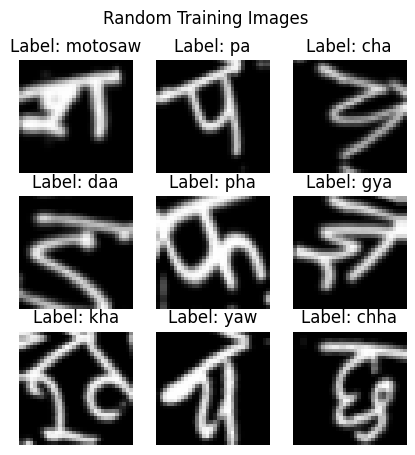

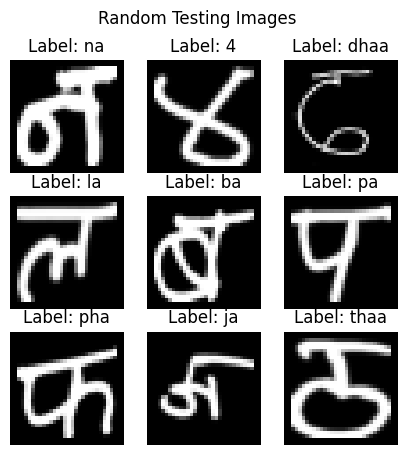

In [8]:
import matplotlib.pyplot as plt

def visualize_images(dataset, title, num_images=9):
    plt.figure(figsize=(5, 5))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f"Label: {class_names[tf.argmax(labels[i])]}")
            plt.axis("off")
    plt.suptitle(title)
    plt.show()

visualize_images(train_dataset, "Random Training Images", num_images=9)
visualize_images(test_dataset, "Random Testing Images", num_images=9)


# PCA

Transforming training images for PCA

In [9]:
train_images, train_labels = [], []
for images, labels in train_dataset:
    train_images.append(images.numpy())
    train_labels.append(labels.numpy())

print("Step 1: Converted TensorFlow dataset to NumPy arrays.")
print("Number of batches in train_images:", len(train_images))
print("Shape of a batch in train_images:", train_images[0].shape)

# Flatten the images and prepare them for PCA
train_images_np = np.concatenate(train_images, axis=0)  # Combine all batches
print("Step 2: Combined all batches into one NumPy array.")
print("Shape of combined train_images_np:", train_images_np.shape)

train_images_flattened = train_images_np.reshape(train_images_np.shape[0], -1)  # Flatten each image into a vector
print("Step 3: Flattened each image into a vector.")
print("Shape of flattened train_images_flattened:", train_images_flattened.shape)

# Conduct PCA using the custom step-by-step implementation
pca_impl = PCA(n_components=0.88)

train_images_pca = pca_impl.fit_transform(train_images_flattened)
print("Step 5: Conducted PCA on the flattened images.")
print("Original shape:", train_images_flattened.shape)
print("Transformed shape:", train_images_pca.shape)

Step 1: Converted TensorFlow dataset to NumPy arrays.
Number of batches in train_images: 782
Shape of a batch in train_images: (100, 32, 32, 3)
Step 2: Combined all batches into one NumPy array.
Shape of combined train_images_np: (78200, 32, 32, 3)
Step 3: Flattened each image into a vector.
Shape of flattened train_images_flattened: (78200, 3072)
Step 5: Conducted PCA on the flattened images.
Original shape: (78200, 3072)
Transformed shape: (78200, 76)


Transforming Test images

In [10]:
test_images, test_labels = [], []
for images, labels in test_dataset:
    test_images.append(images.numpy())
    test_labels.append(labels.numpy())

print("Step 1: Converted TensorFlow dataset to NumPy arrays.")
print("Number of batches in test_images:", len(test_images))
print("Shape of a batch in test_images:", test_images[0].shape)

# Flatten the images and prepare them for PCA
test_images_np = np.concatenate(test_images, axis=0)  # Combine all batches
print("Step 2: Combined all batches into one NumPy array.")
print("Shape of combined test_images_np:", test_images_np.shape)

test_images_flattened = test_images_np.reshape(test_images_np.shape[0], -1)  # Flatten each image into a vector
print("Step 3: Flattened each image into a vector.")
print("Shape of flattened test_images_flattened:", test_images_flattened.shape)

# Conduct PCA using the custom step-by-step implementation
test_images_pca = pca_impl.transform(test_images_flattened)
print("Step 5: Conducted PCA on the flattened images.")
print("Original shape:", test_images_flattened.shape)
print("Transformed shape:", test_images_pca.shape)

Step 1: Converted TensorFlow dataset to NumPy arrays.
Number of batches in test_images: 138
Shape of a batch in test_images: (100, 32, 32, 3)
Step 2: Combined all batches into one NumPy array.
Shape of combined test_images_np: (13800, 32, 32, 3)
Step 3: Flattened each image into a vector.
Shape of flattened test_images_flattened: (13800, 3072)
Step 5: Conducted PCA on the flattened images.
Original shape: (13800, 3072)
Transformed shape: (13800, 76)


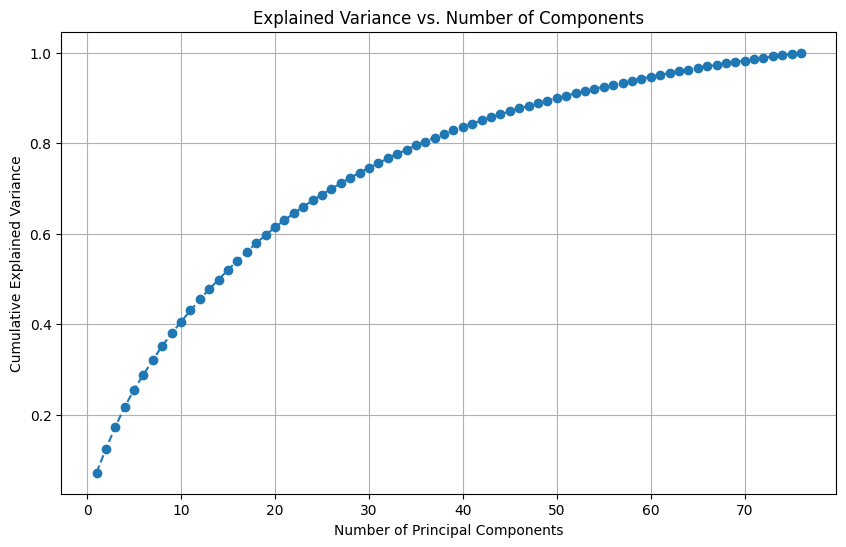

Component 45: Cumulative Explained Variance = 0.8706
Component 46: Cumulative Explained Variance = 0.8768
Component 47: Cumulative Explained Variance = 0.8829
Component 48: Cumulative Explained Variance = 0.8884


In [11]:
# Plot Eigen values 
def plot_explained_variance(eigenvalues, n_components):
    total_variance = np.sum(eigenvalues)
    explained_variance_ratio = [(i / total_variance) for i in sorted(eigenvalues, reverse=True)]
    cumulative_variance = np.cumsum(explained_variance_ratio)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance vs. Number of Components')
    plt.grid()
    plt.show()

    for i, variance in enumerate(cumulative_variance):
        if abs(variance - n_components)<=0.01: 
            print(f"Component {i+1}: Cumulative Explained Variance = {variance:.4f}")

# Plotting Explained Variance
plot_explained_variance(pca_impl.explained_variance_, pca_impl.n_components)

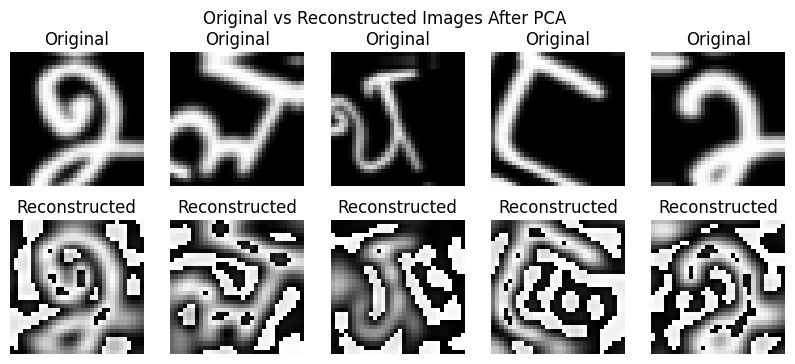

In [12]:
# Reshape reduced data back to image dimensions for visualization (if possible)
num_samples_to_plot = 5
reconstructed_images = pca_impl.inverse_transform(train_images_pca[:num_samples_to_plot])
reconstructed_images = reconstructed_images.reshape((num_samples_to_plot, 32, 32, 3))

# Plot original vs reconstructed images
plt.figure(figsize=(10, 4))
for i in range(num_samples_to_plot):
    # Original Image
    plt.subplot(2, num_samples_to_plot, i + 1)
    plt.imshow(train_images_np[i].astype('uint8'))
    plt.title("Original")
    plt.axis('off')

    # Reconstructed Image
    plt.subplot(2, num_samples_to_plot, num_samples_to_plot + i + 1)
    plt.imshow(reconstructed_images[i].astype('uint8'))
    plt.title("Reconstructed")
    plt.axis('off')

plt.suptitle("Original vs Reconstructed Images After PCA")
plt.show()

# Machine Learning Models

### Generic Classifier function

In [13]:
def genericClassifier(clfr, x_train_data, y_train_data, x_test_data, y_test_data, acc_str, matrix_header_str):
    clfr.fit(x_train_data, y_train_data)
    y_pred = clfr.predict(x_test_data)

    print(acc_str.format(accuracy_score(y_test_data, y_pred) * 100))
    acc = accuracy_score(y_test_data, y_pred) * 100
    f1 = f1_score(y_test_data.argmax(axis=1), y_pred.argmax(axis=1), average='weighted') if len(y_test_data.shape) > 1 else f1_score(y_test_data, y_pred, average='weighted')
    print("F1 Score =", f1)
    return y_pred, acc, f1

### Gaussian Naive Bayes Classifier

In [14]:
train_labels= np.concatenate(train_labels, axis=0)  # Merges into one array
test_labels= np.concatenate(test_labels, axis=0)  # Merges into one array

In [15]:
naiveBayesClassifier = GaussianNB(var_smoothing=1e-8)
y_pred_nb, nb_acc, nb_f1 = genericClassifier(
    naiveBayesClassifier,
    train_images_pca,
    train_labels.argmax(axis=1),
    test_images_pca,
    test_labels.argmax(axis=1),
    "Naive Bayes Accuracy: {0:0.1f}%", "Naive Bayes Confusion matrix")

Naive Bayes Accuracy: 49.8%
F1 Score = 0.4954739831687412


### KNN

In [16]:
knnClassifier = KNeighborsClassifier(n_neighbors=10, weights='distance', algorithm='ball_tree', n_jobs=-1)
y_pred_knn, knn_acc, knn_f1 = genericClassifier(
    knnClassifier, 
    train_images_pca,
    train_labels.argmax(axis=1),
    test_images_pca,
    test_labels.argmax(axis=1),
    "KNN Accuracy: {0:0.1f}%", "KNN Confusion matrix")

KNN Accuracy: 83.1%
F1 Score = 0.8305325170604382


### Multi-Layer Perceptron (for Shallow neural network)

In [17]:
mlpClassifier = MLPClassifier(hidden_layer_sizes=(64, 128, 256), max_iter = 400)
y_pred_mlp, mlp_acc, mlp_f1 = genericClassifier(
    mlpClassifier, 
    train_images_pca,
    train_labels.argmax(axis=1),
    test_images_pca,
    test_labels.argmax(axis=1),
    "MLP Classifier Accuracy: {0:0.1f}%", "MLP Classifier Confusion matrix")

MLP Classifier Accuracy: 78.3%
F1 Score = 0.7819125719513319


# Deep Learning Models

### CNN

In [18]:
input_shape = (32, 32, 3)
num_classes = len(class_names)

In [19]:
def vanilla_cnn(input_shape, num_classes):
    model = tf.keras.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        
        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.BatchNormalization(),
        # layers.Dropout(0.3),
        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),

        # Fully Connected Layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),

        layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),

        # Output Layer
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy','f1_score'])
    return model


In [20]:
# Vanilla CNN
vanilla_cnn_model = vanilla_cnn(input_shape, num_classes)
history_cnn = vanilla_cnn_model.fit(train_dataset, validation_data=test_dataset, epochs=30)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1742796152.180542      74 service.cc:145] XLA service 0x7c67700064c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742796152.180599      74 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 25/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.0484 - f1_score: 0.0362 - loss: 6.2204

I0000 00:00:1742796156.789383      74 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.3893 - f1_score: 0.3841 - loss: 3.6807 - val_accuracy: 0.8949 - val_f1_score: 0.8946 - val_loss: 0.8363
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7826 - f1_score: 0.7814 - loss: 1.1222 - val_accuracy: 0.9309 - val_f1_score: 0.9313 - val_loss: 0.5689
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8441 - f1_score: 0.8434 - loss: 0.8431 - val_accuracy: 0.9249 - val_f1_score: 0.9245 - val_loss: 0.5581
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8660 - f1_score: 0.8653 - loss: 0.7440 - val_accuracy: 0.9230 - val_f1_score: 0.9233 - val_loss: 0.5549
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8781 - f1_score: 0.8777 - loss: 0.6987 - val_accuracy: 0.8984 - val_f1_score: 0.8982 - val_loss: 0.6569
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8844 - f1_score: 0.8840 - loss: 0.6590 - val_accuracy: 0.8849 - val_f1_score: 0.8841 - val_los

In [21]:
train_loss, train_accuracy, _ = vanilla_cnn_model.evaluate(train_dataset)
validate_loss, validate_accuracy, _ = vanilla_cnn_model.evaluate(test_dataset)
print("Train: accuracy = %f  ;  loss_v = %f" % (train_accuracy, train_loss))
print("Validation: accuracy = %f  ;  loss_v = %f" % (validate_accuracy, validate_loss))

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9559 - f1_score: 0.9557 - loss: 0.3430
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9512 - f1_score: 0.9501 - loss: 0.4081
Train: accuracy = 0.960716  ;  loss_v = 0.329965
Validation: accuracy = 0.947826  ;  loss_v = 0.416494


In [22]:
def efficientnet_model(input_shape, num_classes):
    base_model = tf.keras.applications.EfficientNetB0(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    # base_model.trainable = False  # Freeze base model layers initially

    model = tf.keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),#'adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'f1_score'])
    return model

In [23]:
# EfficientNet
efficientnet = efficientnet_model(input_shape, num_classes)
history_efficient = efficientnet.fit(train_dataset, validation_data=test_dataset, epochs=20)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 108s 39ms/step - accuracy: 0.2840 - f1_score: 0.2755 - loss: 2.7726 - val_accuracy: 0.9002 - val_f1_score: 0.9001 - val_loss: 0.4221
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.8135 - f1_score: 0.8129 - loss: 0.7375 - val_accuracy: 0.9363 - val_f1_score: 0.9369 - val_loss: 0.2664
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 33ms/step - accuracy: 0.8821 - f1_score: 0.8818 - loss: 0.4787 - val_accuracy: 0.9477 - val_f1_score: 0.9478 - val_loss: 0.2216
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.9096 - f1_score: 0.9094 - loss: 0.3745 - val_accuracy: 0.9612 - val_f1_score: 0.9611 - val_loss: 0.1745
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.9220 - f1_score: 0.9217 - loss: 0.3169 - val_accuracy: 0.9612 - val_f1_score: 0.9611 - val_loss: 0.1974
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.9309 - f1_score: 0.9

In [24]:
train_loss, train_accuracy, _ = efficientnet.evaluate(train_dataset)
validate_loss, validate_accuracy, _ = efficientnet.evaluate(test_dataset)
print("Train: accuracy = %f  ;  loss_v = %f" % (train_accuracy, train_loss))
print("Validation: accuracy = %f  ;  loss_v = %f" % (validate_accuracy, validate_loss))

782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9867 - f1_score: 0.9866 - loss: 0.0652
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9758 - f1_score: 0.9749 - loss: 0.1555
Train: accuracy = 0.987698  ;  loss_v = 0.059135
Validation: accuracy = 0.976667  ;  loss_v = 0.153954


In [25]:
def mobilenet_model(input_shape, num_classes):
    base_model = tf.keras.applications.MobileNetV3Small(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    # base_model.trainable = False  # Freeze base model layers initially

    model = tf.keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),#'adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy','f1_score'])
    return model

In [26]:
# MobileNet
mobilenet = mobilenet_model(input_shape, num_classes)
history_mobilenet = mobilenet.fit(train_dataset, validation_data=test_dataset, epochs=20)

/opt/conda/lib/python3.10/site-packages/keras/src/applications/mobilenet_v3.py:449: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 54s 21ms/step - accuracy: 0.1760 - f1_score: 0.1682 - loss: 3.3701 - val_accuracy: 0.1330 - val_f1_score: 0.0894 - val_loss: 4.1075
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.6839 - f1_score: 0.6816 - loss: 1.0974 - val_accuracy: 0.4021 - val_f1_score: 0.3531 - val_loss: 2.7038
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8094 - f1_score: 0.8084 - loss: 0.6641 - val_accuracy: 0.7086 - val_f1_score: 0.7037 - val_loss: 1.1127
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8561 - f1_score: 0.8555 - loss: 0.4876 - val_accuracy: 0.7895 - val_f1_score: 0.7867 - val_loss: 0.7743
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8855 - f1_score: 0.8851 - loss: 0.3843 - val_accuracy: 0.8741 - val_f1_score: 0.8726 - val_loss: 0.4639
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.9036 - f1_score: 0.9033

In [27]:
train_loss, train_accuracy, _ = mobilenet.evaluate(train_dataset)
validate_loss, validate_accuracy, _ = mobilenet.evaluate(test_dataset)
print("Train: accuracy = %f  ;  loss_v = %f" % (train_accuracy, train_loss))
print("Validation: accuracy = %f  ;  loss_v = %f" % (validate_accuracy, validate_loss))

782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9247 - f1_score: 0.9244 - loss: 0.3176
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8927 - f1_score: 0.8896 - loss: 0.6086
Train: accuracy = 0.927762  ;  loss_v = 0.305254
Validation: accuracy = 0.886449  ;  loss_v = 0.650623


### Deep Belief Networks

In [28]:
def extract_data(dataset):
    images, labels = [], []
    for img_batch, label_batch in dataset:
        images.extend(img_batch.numpy().reshape(len(img_batch), -1))  # Flatten images
        labels.extend(tf.argmax(label_batch, axis=1).numpy())  # Decode one-hot labels
    return np.array(images) / 255.0, np.array(labels)

# Extract data from train_dataset and test_dataset
train_images, train_labels = extract_data(train_dataset)
test_images, test_labels = extract_data(test_dataset)

# One-hot encode labels for DBN fine-tuning
num_classes = len(class_names)
train_labels_onehot = tf.keras.utils.to_categorical(train_labels, num_classes)
test_labels_onehot = tf.keras.utils.to_categorical(test_labels, num_classes)

In [29]:
class RBM(tf.keras.layers.Layer):
    def __init__(self, visible_units, hidden_units, learning_rate=0.01):
        super(RBM, self).__init__()
        self.visible_units = visible_units
        self.hidden_units = hidden_units
        self.learning_rate = learning_rate
        self.built = False

    def build(self, input_shape):
        # Initialize weights and biases with unique names
        self.rbm_weights = self.add_weight(
            shape=(self.visible_units, self.hidden_units),
            initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1),
            trainable=True,
            name="rbm_weights"
        )
        self.hidden_bias = self.add_weight(
            shape=(self.hidden_units,),
            initializer="zeros",
            trainable=True,
            name="hidden_bias"
        )
        self.visible_bias = self.add_weight(
            shape=(self.visible_units,),
            initializer="zeros",
            trainable=True,
            name="visible_bias"
        )
        self.built = True

    def forward(self, visible):
        # Ensure weights are initialized
        if not self.built:
            self.build((None, visible.shape[1]))
        hidden_prob = tf.nn.sigmoid(tf.matmul(visible, self.rbm_weights) + self.hidden_bias)
        hidden_states = tf.cast(hidden_prob > tf.random.uniform(tf.shape(hidden_prob)), tf.float32)
        return hidden_prob, hidden_states

    def backward(self, hidden):
        visible_prob = tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(self.rbm_weights)) + self.visible_bias)
        return visible_prob

    def train(self, inputs):
        # Forward pass
        hidden_prob, hidden_states = self.forward(inputs)

        # Backward pass
        reconstructed_visible_prob = self.backward(hidden_states)
        reconstructed_hidden_prob, _ = self.forward(reconstructed_visible_prob)

        # Compute gradients
        positive_grad = tf.matmul(tf.transpose(inputs), hidden_prob)
        negative_grad = tf.matmul(tf.transpose(reconstructed_visible_prob), reconstructed_hidden_prob)

        # Update weights and biases
        self.rbm_weights.assign_add(self.learning_rate * (positive_grad - negative_grad) / tf.cast(tf.shape(inputs)[0], tf.float32))
        self.visible_bias.assign_add(self.learning_rate * tf.reduce_mean(inputs - reconstructed_visible_prob, axis=0))
        self.hidden_bias.assign_add(self.learning_rate * tf.reduce_mean(hidden_prob - reconstructed_hidden_prob, axis=0))

In [30]:
class DBN:
    def __init__(self, layer_sizes, learning_rate=0.01):
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.rbms = [RBM(layer_sizes[i], layer_sizes[i + 1], learning_rate) for i in range(len(layer_sizes) - 1)]

    def pretrain(self, data, epochs=10):
        input_data = data
        for i, rbm in enumerate(self.rbms):
            print(f"Training RBM {i + 1}/{len(self.rbms)}")
            for epoch in range(epochs):
                rbm.train(input_data)
            input_data, _ = rbm.forward(input_data)

    def fine_tune(self, data, labels, epochs=10, dropout_rate = 0.3):
        model = tf.keras.Sequential()
        input_size = self.layer_sizes[0]  # Start with the input size of the data

        i = 0
        # Add layers corresponding to pretrained RBMs
        for rbm in self.rbms:
            # Add Dense layer without initializing weights
            dense_layer = tf.keras.layers.Dense(
                rbm.hidden_units,
                activation="sigmoid",
                trainable=True
            )
            model.add(dense_layer)
    
            # Force the layer to build by providing the correct input shape
            dense_layer.build(input_shape=(None, input_size))
    
            # Set the pretrained weights and biases
            dense_layer.set_weights([rbm.rbm_weights.numpy(), rbm.hidden_bias.numpy()])

            # adding drop layer
            if i%2==0:
                model.add(tf.keras.layers.Dropout(rate=dropout_rate))
                i+=1

            model.add(layers.BatchNormalization())
            
            # Update input size for the next layer
            input_size = rbm.hidden_units
    
        # Add final classification layer
        model.add(
            tf.keras.layers.Dense(
                labels.shape[1],
                activation="softmax"
            )
        )
    
        # Compile the model
        model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", "f1_score"])
    
        # Train the model
        history = model.fit(data, labels, epochs=epochs, validation_split=0.2)
        return model, history
    def predict(self, data):
        # Forward pass through all the RBMs (unsupervised feature extraction)
        input_data = data
        for rbm in self.rbms:
            # Compute the hidden probabilities and use them as input to the next RBM
            hidden_prob, _ = rbm.forward(input_data)
            input_data = hidden_prob
    
        # Forward pass through the fine-tuned model (supervised prediction)
        predictions = self.fine_tuned_model.predict(input_data)
        predicted_labels = np.argmax(predictions, axis=1)  # Convert probabilities to class labels
    
        return predicted_labels

In [31]:
# Define DBN architecture
input_dim = train_images.shape[1]  # Number of flattened input features
layer_sizes = [input_dim, 1024, 512, 512]  # Input layer and two hidden layers

# Initialize the DBN
dbn = DBN(layer_sizes, learning_rate=0.01)

# Pretrain the DBN
dbn.pretrain(train_images, epochs=15)

# Fine-tune the DBN for classification
model, history_dbn = dbn.fine_tune(train_images, train_labels_onehot, epochs=60)

# Evaluate the DBN
test_loss, test_accuracy, results = model.evaluate(test_images, test_labels_onehot)
print(f"Test Accuracy: {test_accuracy:.2f}")

Training RBM 1/3
Training RBM 2/3
Training RBM 3/3
Epoch 1/60
1955/1955 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.2746 - f1_score: 0.2652 - loss: 2.8363 - val_accuracy: 0.5538 - val_f1_score: 0.5485 - val_loss: 1.5569
Epoch 2/60
1955/1955 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5175 - f1_score: 0.5102 - loss: 1.6898 - val_accuracy: 0.6335 - val_f1_score: 0.6300 - val_loss: 1.2758
Epoch 3/60
1955/1955 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5891 - f1_score: 0.5845 - loss: 1.4100 - val_accuracy: 0.6666 - val_f1_score: 0.6624 - val_loss: 1.1310
Epoch 4/60
1955/1955 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6357 - f1_score: 0.6319 - loss: 1.2361 - val_accuracy: 0.6820 - val_f1_score: 0.6768 - val_loss: 1.0725
Epoch 5/60
1955/1955 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6566 - f1_score: 0.6530 - loss: 1.1457 - val_accuracy: 0.7031 - val_f1_score: 0.7011 - val_loss: 0.9967
Epoch 6/60
1955/1955 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6813 - f1_score: 0.6

In [32]:
train_loss, train_accuracy, results = model.evaluate(test_images, test_labels_onehot)

432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9034 - f1_score: 0.9000 - loss: 0.3270


# Plots

### Plotting history

In [33]:
def plot_model_history(hist, model_name):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title(f'Training and Validation Loss: {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title(f'Training and Validation Accuracy: {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout
    plt.show()

In [34]:
def plot_confusion_matrix(model, test_dataset, class_names):
    """
    Plots a formatted confusion matrix for better readability.
    :param model: Trained model to evaluate.
    :param test_dataset: Dataset to test the model on.
    :param class_names: List of class labels.
    """
    # Get true labels and predictions
    y_true = []
    y_pred = []

    for images, labels in test_dataset:
        # True labels
        y_true.extend(np.argmax(labels.numpy(), axis=1))
        # Predicted labels
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix with formatting
    fig, ax = plt.subplots(figsize=(12, 12))  # Adjust the figure size for readability
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(
        include_values=True,  # Show values inside the matrix
        cmap=plt.cm.Blues,    # Use a color map
        xticks_rotation=45,   # Rotate x-axis labels
        ax=ax                 # Use the custom-sized figure
    )
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()


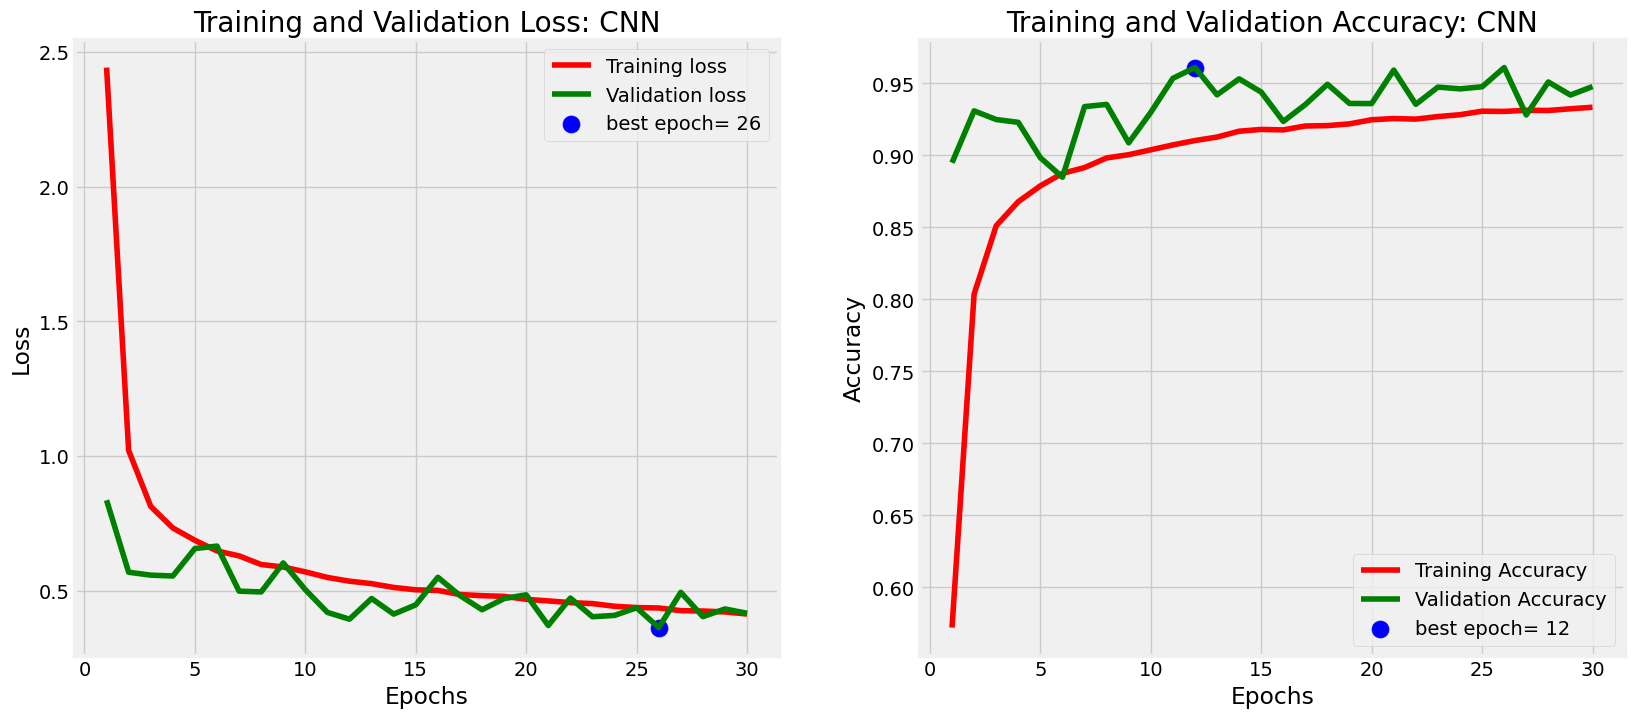

In [35]:
plot_model_history(history_cnn,'CNN')

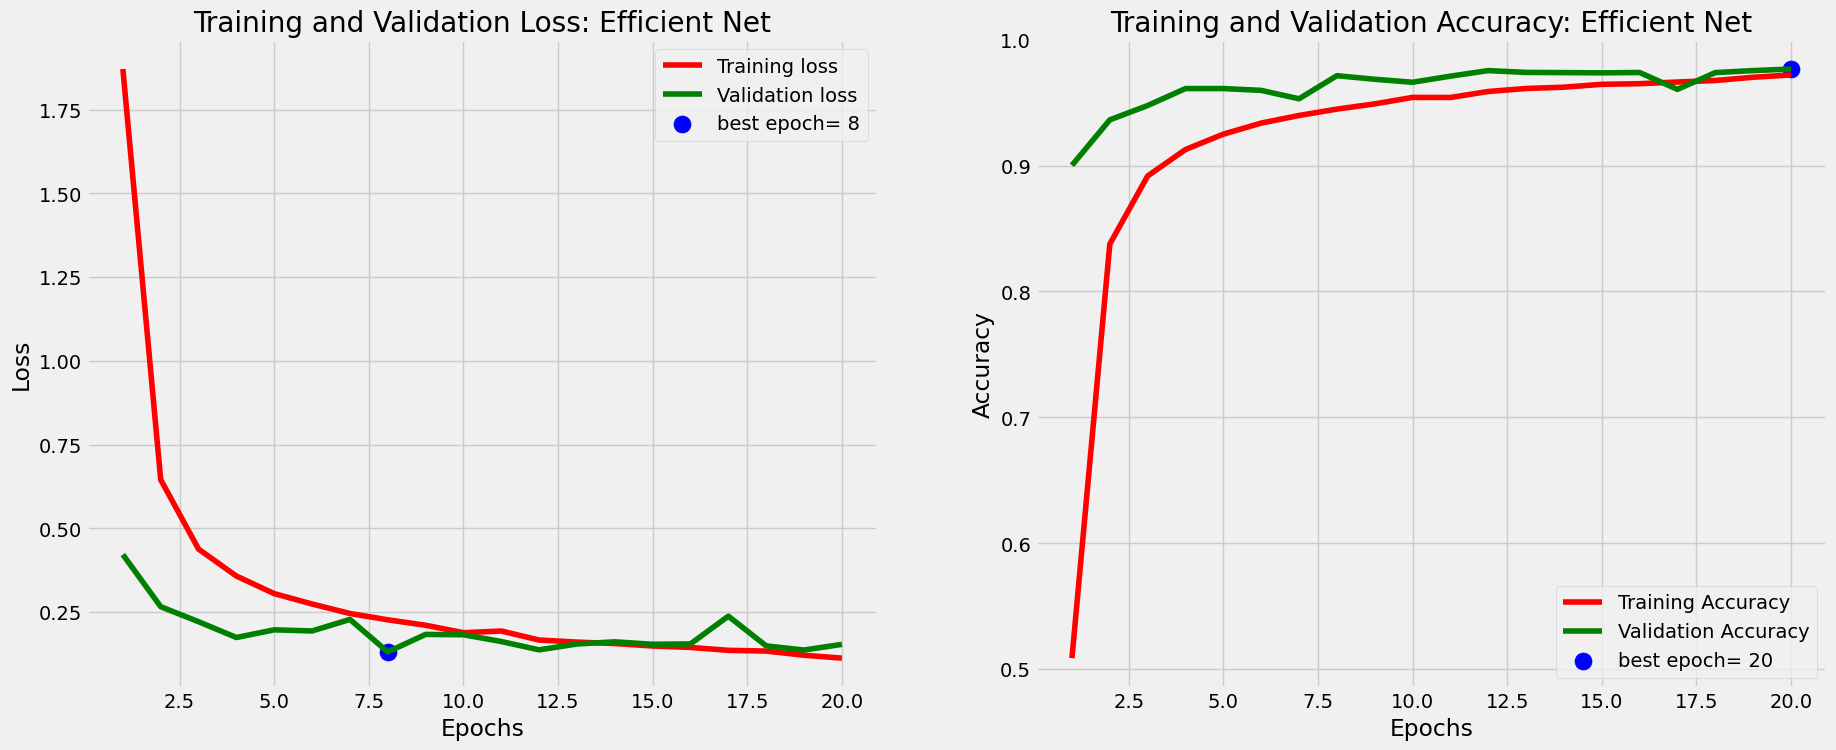

In [36]:
plot_model_history(history_efficient,'Efficient Net')

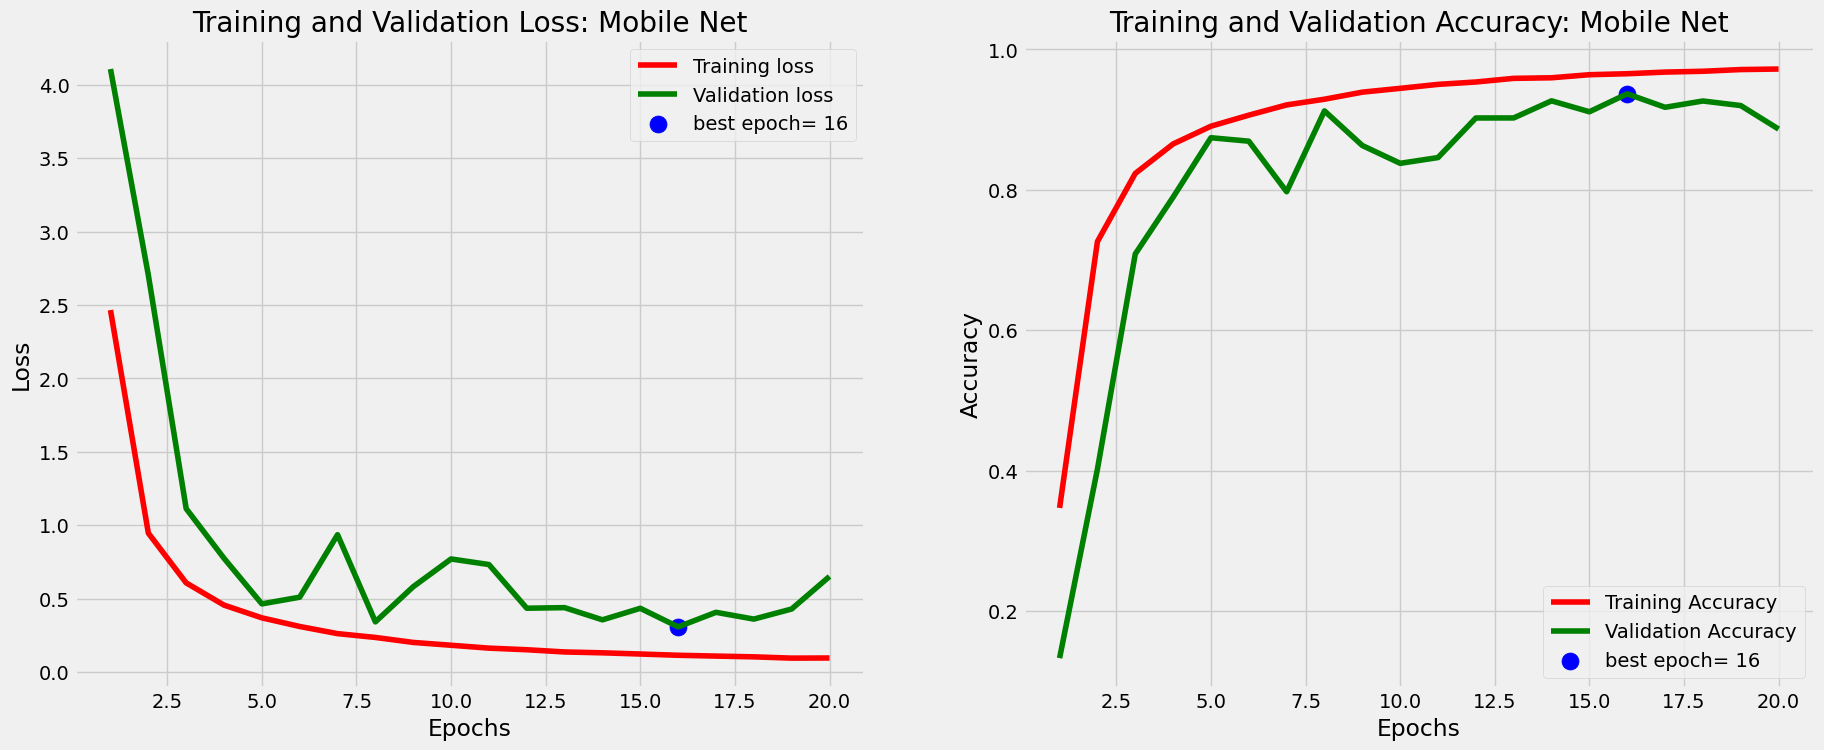

In [37]:
plot_model_history(history_mobilenet,'Mobile Net')

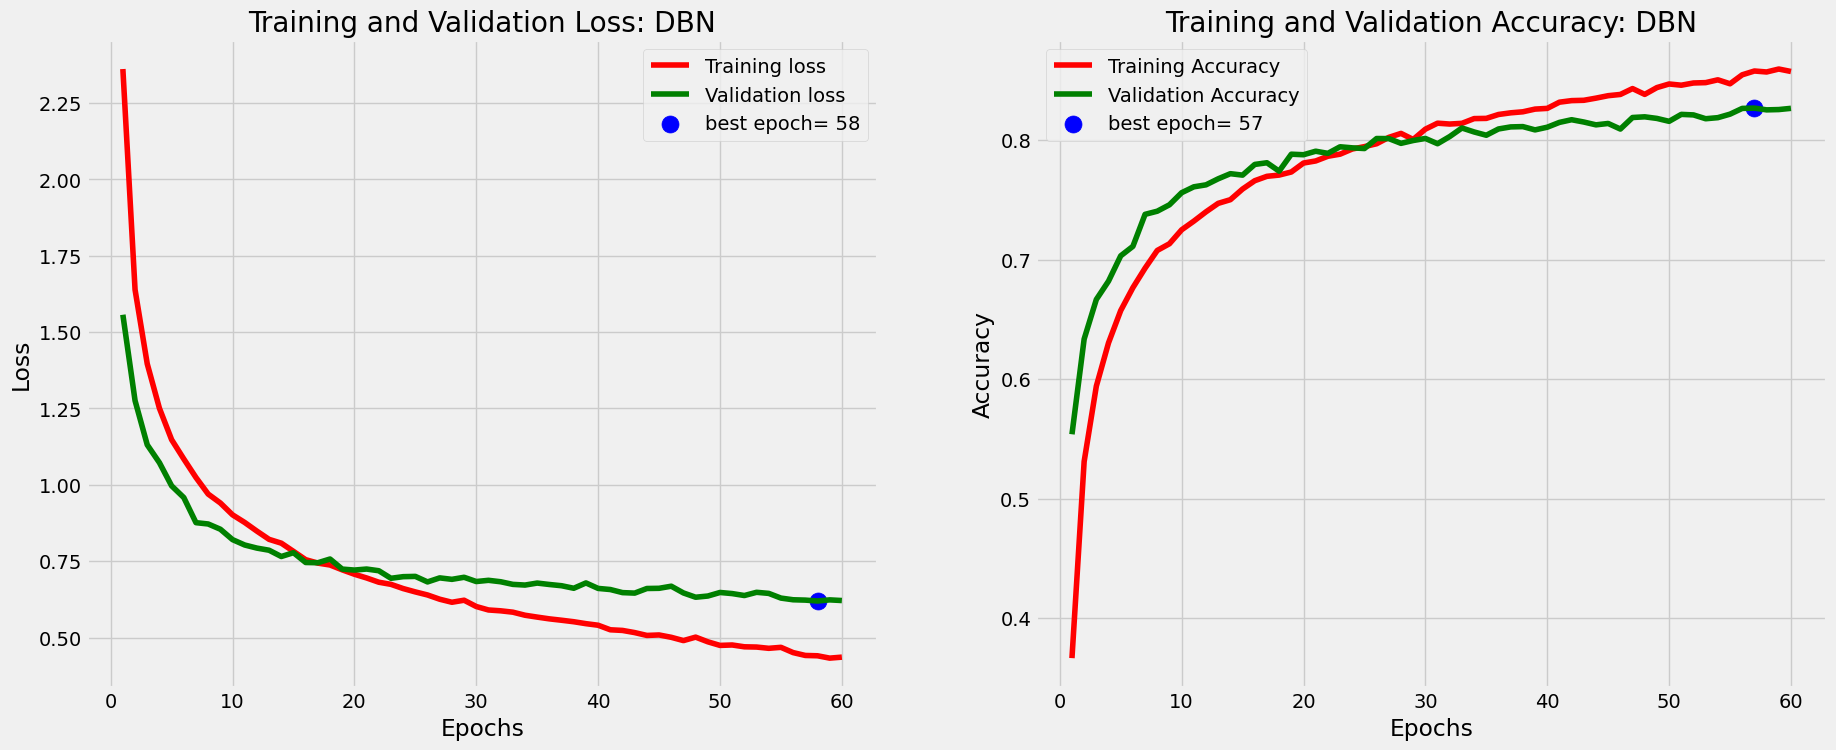

In [38]:
plot_model_history(history_dbn,'DBN')

Confusion Matrix

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━

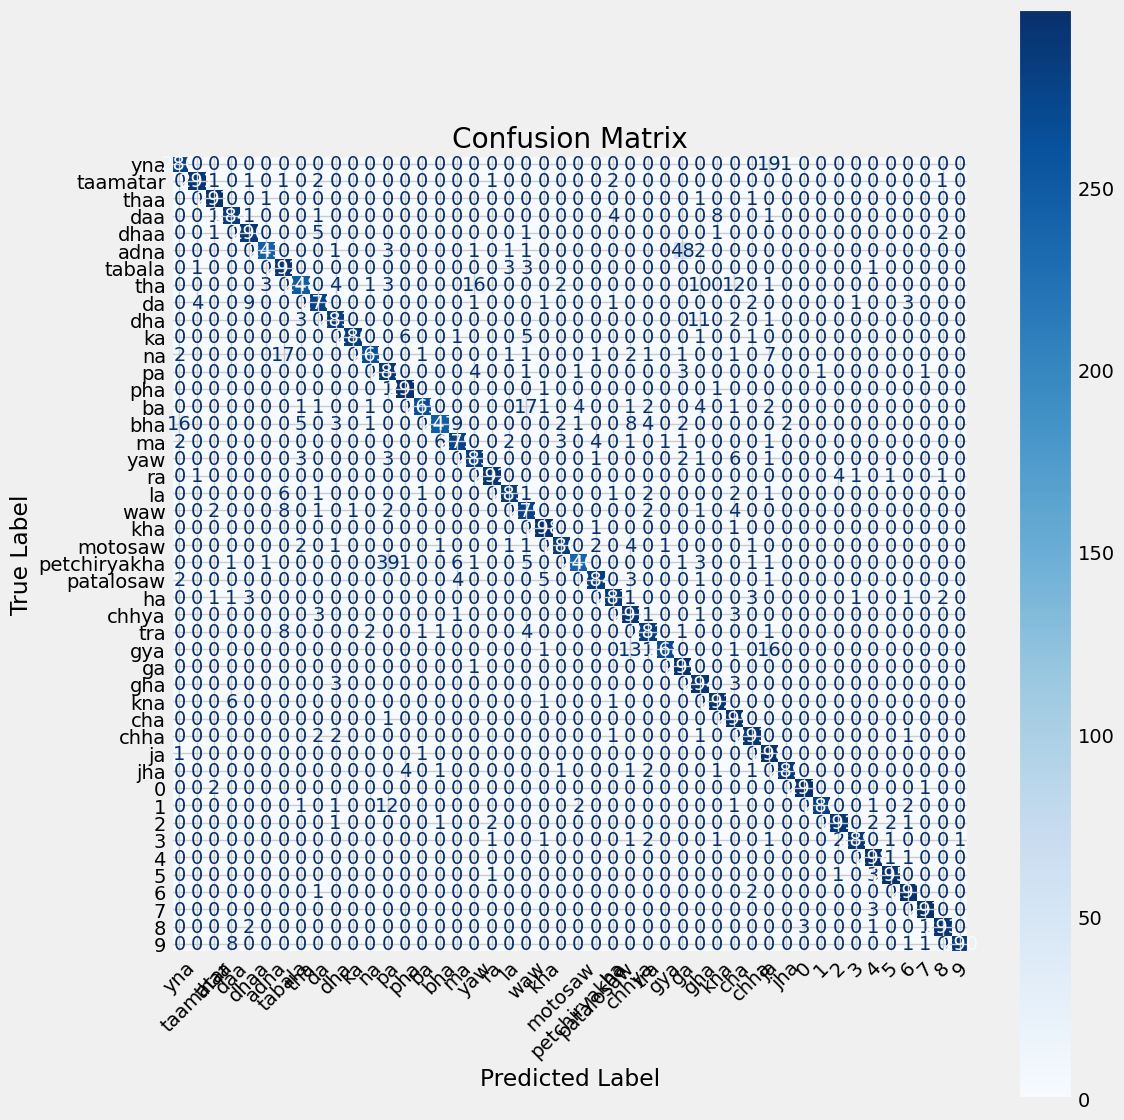

In [39]:
_ = plot_confusion_matrix(vanilla_cnn_model, test_dataset, class_names)

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━

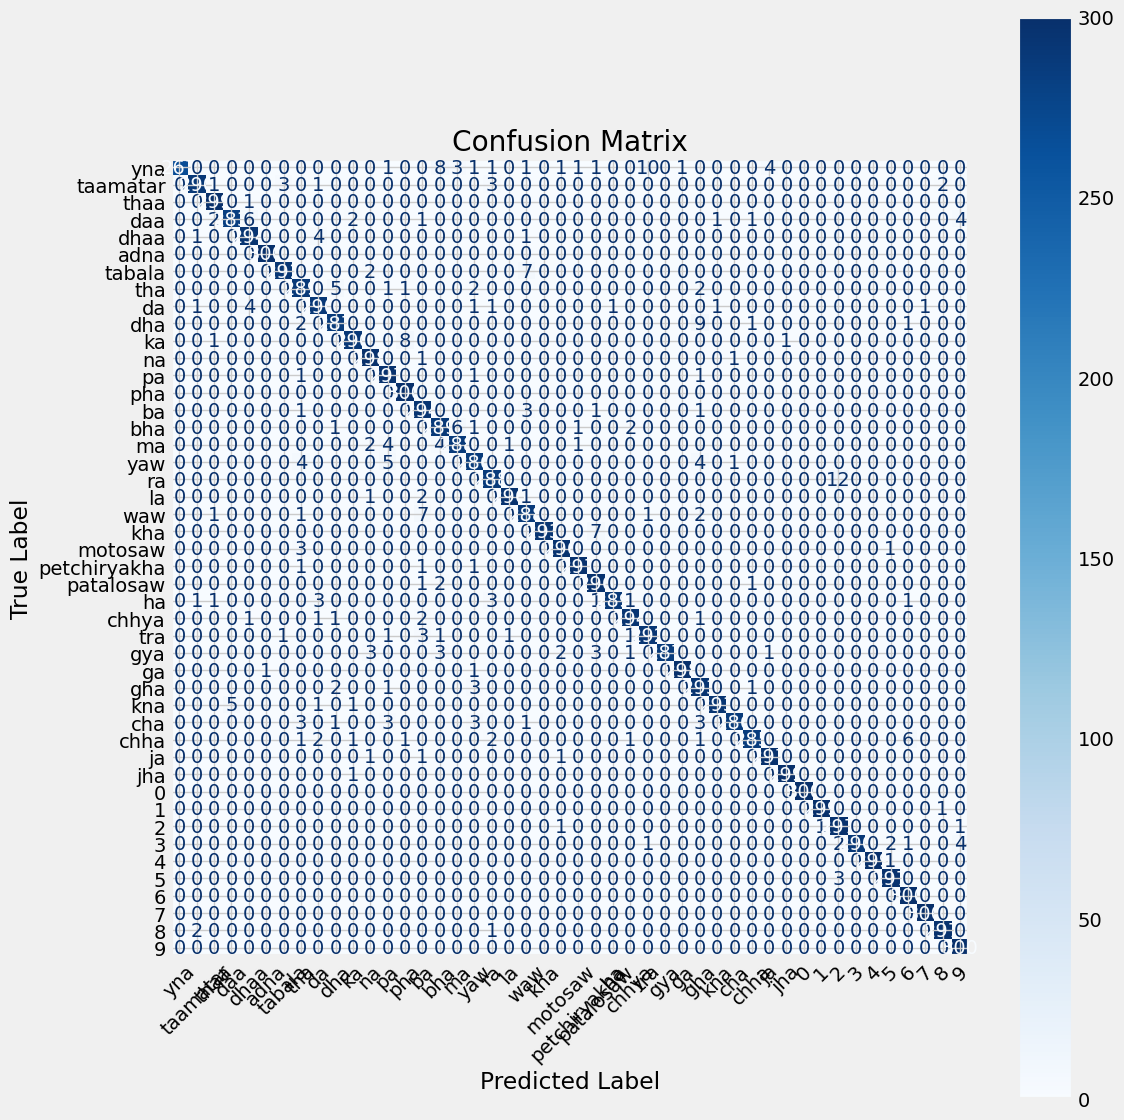

In [40]:
plot_confusion_matrix(efficientnet, test_dataset, class_names)

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━

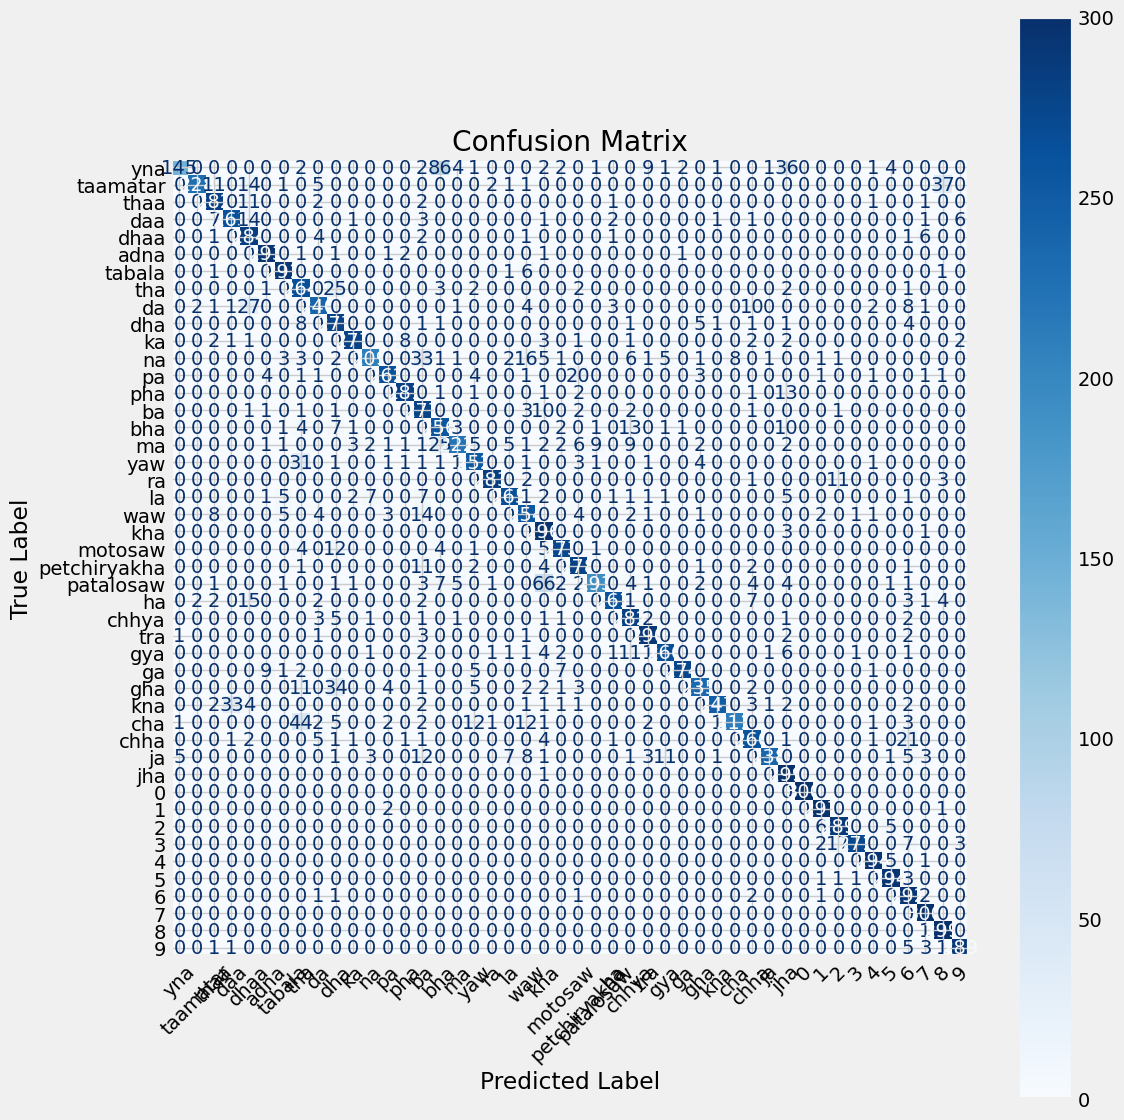

In [41]:
plot_confusion_matrix(mobilenet, test_dataset, class_names)